In [49]:
import sys
import pandas
import numpy as np
import imblearn
import sklearn
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA




from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

pandas.set_option('display.max_columns', None)
# pandas.set_option('display.max_rows', None)

In [2]:
df = pandas.read_csv("ufcdata/data.csv").drop(columns = ["Referee", "R_fighter", "B_fighter", "location", "date"]).dropna().reset_index()
df = df.drop(columns = ["index"])
df.title_bout = df.title_bout.astype(int)

df["Winner"][df["Winner"] == "Red"] = 1
df["Winner"][df["Winner"] == "Blue"] = 0
df["Winner"][df["Winner"] == "Draw"] = 3

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [3]:
# list(df.keys())
R_status = []
B_status = []
global_status = []
for i in list(df.keys()):
    if("R_" in i[:3]):
        R_status.append(i)
    elif("B_" in i):
        B_status.append(i)
    else:
        global_status.append(i)
B_status.remove("B_Stance")
R_status.remove("R_Stance")

len(R_status), len(B_status)

(67, 67)

In [4]:
len(global_status)
global_status

['Winner', 'title_bout', 'weight_class', 'no_of_rounds']

In [5]:
df1 = pandas.DataFrame()
for side in ["R_", "B_"]:
    keys = list(sorted(df[side+"Stance"].unique()))
    lis = list()
    for i in df[side+"Stance"].tolist():
        zero = np.zeros((1,len(keys)))
        zero[0][keys.index(i)] = 1
        lis.append(zero[0])
    _keys = []
    for i in keys:
        _keys.append(side+i)
    df_temp = pandas.DataFrame(lis, columns = _keys)
    
    for i in df_temp.keys():
        df1[i] = df_temp[i]


In [6]:
keys = list(sorted(df["weight_class"].unique()))
lis = list()
for i in df["weight_class"].tolist():
    zero = np.zeros((1,len(keys)))
    zero[0][keys.index(i)] = 1
    lis.append(zero[0])
_keys = []
for i in keys:
    _keys.append(i)
df2 = pandas.DataFrame(lis, columns = _keys)


In [7]:
drop_list = ["R_Stance", "B_Stance", "weight_class"]
df = pandas.concat([df, df1,df2], axis=1).drop(columns = drop_list)

In [8]:
df = df.astype('float')
df

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
0,1.0,1.0,5.0,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.600000,5.400000,0.400000,0.000000,65.400000,22.600000,0.466000,0.400000,0.800000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.600000,51.200000,17.400000,0.600000,0.200000,39.600000,9.400000,0.200000,6.800000,4.800000,0.000000,0.000000,52.800000,18.200000,0.236000,0.000000,1.000000,0.400000,0.100000,53.800000,19.200000,9.0,419.400000,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,167.64,170.18,135.0,0.0,4.0,0.0,21.900000,16.400000,17.000000,11.000000,75.000000,26.500000,9.400000,6.500000,74.200000,23.900000,0.400000,5.300000,3.700000,1.200000,0.000000,101.400000,44.000000,0.466000,0.100000,5.300000,1.900000,0.458000,129.900000,69.100000,4.0,2.0,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.600000,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,5.0,0.0

In [9]:

new_key = []
for i in B_status:
    new_key.append(i.replace("B_", "Difference"))
new_key

df3 = pandas.DataFrame(df[B_status].to_numpy() - df[R_status].to_numpy(), columns = new_key)
df3
# df[B_status]
# B_status

,Differencecurrent_lose_streak,Differencecurrent_win_streak,Differencedraw,Differenceavg_BODY_att,Differenceavg_BODY_landed,Differenceavg_CLINCH_att,Differenceavg_CLINCH_landed,Differenceavg_DISTANCE_att,Differenceavg_DISTANCE_landed,Differenceavg_GROUND_att,Differenceavg_GROUND_landed,Differenceavg_HEAD_att,Differenceavg_HEAD_landed,Differenceavg_KD,Differenceavg_LEG_att,Differenceavg_LEG_landed,Differenceavg_PASS,Differenceavg_REV,Differenceavg_SIG_STR_att,Differenceavg_SIG_STR_landed,Differenceavg_SIG_STR_pct,Differenceavg_SUDifferenceATT,Differenceavg_TD_att,Differenceavg_TD_landed,Differenceavg_TD_pct,Differenceavg_TOTAL_STR_att,Differenceavg_TOTAL_STR_landed,Differencelongest_win_streak,Differencelosses,Differenceavg_opp_BODY_att,Differenceavg_opp_BODY_landed,Differenceavg_opp_CLINCH_att,Differenceavg_opp_CLINCH_landed,Differenceavg_opp_DISTANCE_att,Differenceavg_opp_DISTANCE_landed,Differenceavg_opp_GROUND_att,Differenceavg_opp_GROUND_landed,Differenceavg_opp_HEAD_att,Differenceavg_opp_HEAD_landed,Differenceavg_opp_KD,Differenceavg_opp_LEG_att,Differenceavg_opp_LEG_landed,Differenceavg_opp_PASS,Differenceavg_opp_REV,Differenceavg_opp_SIG_STR_att,Differenceavg_opp_SIG_STR_landed,Differenceavg_opp_SIG_STR_pct,Differenceavg_opp_SUDifferenceATT,Differenceavg_opp_TD_att,Differenceavg_opp_TD_landed,Differenceavg_opp_TD_pct,Differenceavg_opp_TOTAL_STR_att,Differenceavg_opp_TOTAL_STR_landed,Differencetotal_rounds_fought,Differencetotal_time_fought(seconds),Differencetotal_title_bouts,Differencewin_by_Decision_Majority,Differencewin_by_Decision_Split,Differencewin_by_Decision_Unanimous,Differencewin_by_KO/TKO,Differencewin_by_Submission,Differencewin_by_TKO_Doctor_Stoppage,Differencewins,DifferenceHeight_cms,DifferenceReach_cms,DifferenceWeight_lbs,Differenceage
0,0.0,0.0,0.0,-12.700000,-10.400000,-16.800000,-11.000000,-12.400000,-5.900000,-6.800000,-4.500000,-25.600000,-12.700000,0.400000,2.300000,1.700000,-0.800000,0.000000,-36.000000,-21.400000,0.000000,0.300000,-4.500000,-1.700000,-0.358000,-63.500000,-45.500000,0.0,-1.0,-6.900000,-4.800000,-6.500000,-4.500000,-39.300000,-9.400000,-0.200000,-0.100000,-36.500000,-7.900000,0.100000,-2.600000,-1.300000,0.000000,0.000000,-46.000000,-14.000000,-0.100000,0.000000,0.100000,0.300000,0.050000,-56.700000,-24.100000,-18.0,-323.200000,-3.0,0.0,-1.0,-4.0,0.0,1.0,0.0,-4.0,5.08,7.62,0.0,-1.0
1,0.0,1.0,0.0,2.600000,1.385714,2.514286,0.442857,36.557143,5.957143,-16.028571,-14.528571,27.428571,-5.000000,0.000000,-6.985714,-4.514286,-0.914286,-0.142857,23.042857,-8.128571,-0.176714,0.271429,-4.142857,-1.928571,-0.376429,-2.871429,-33.257143,1.0,4.0,-11.571429,-4.842857,2.228571,1.742857,3.128571,-0.571429,1.671429,2.614286,35.842857,18.371429,0.100000,-17.242857,-9.742857,0.257143,0.000000,7.028571,3.785714,-0.029143,0.414286,-0.985714,0.042857,0.083857,-6.642857,-6.885714,4.0,-213.000000,-2.0,0.0,1.0,-1.0,0.0,-2.0,1.0,-1.0,2.54,0.00,0.0,1.0
2,0.0,-8.0,0.0,1.488172,2.655914,3.875269,2.653763,-31.391398,-10.886022,0.182796,-0.460215,-29.088172,-12.341935,0.445161,0.266667,0.993548,0.602151,-0.036559,-27.333333,-8.692473,0.066129,-0.645161,1.227957,0.277419,0.018151,-29.290323,-10.851613,-3.0,7.0,3.436559,3.737634,5.619355,5.105376,-6.518280,5.864516,-3.124731,-1.864516,-10.621505,2.283871,-0.040860,3.161290,3.083871,-0.301075,-0.101075,-4.023656,9.105376,0.113226,0.030108,-0.769892,-0.440860,-0.067785,-1.746237,11.174194,35.0,-22.529032,-1.0,0.0,-1.0,4.0,7.0,0.0,-1.0,9.0,5.08,-7.62,0.0,1.0
3,-1.0,4.0,0.0,-1.250000,3.750000,7.875000,6.875000,4.625000,7.750000,12.000000,9.875000,35.750000,29.750000,0.125000,-10.000000,-9.000000,0.375000,0.250000,24.500000,24.500000,0.183750,0.250000,0.250000,0.625000,0.183750,37.375000,36.000000,-1.0,-2.0,-8.000000,-7.375000,-0.875000,-1.875000,-8.875000,-11.750000,0.875000,0.500000,5.125000,1.125000,0.125000,-6.000000,-6.875000,0.000000,0.000000,-8.875000,-13.125000,-0.108750,0.000000,2.125000,0.750000,0.097500,-10.375000,-14.625000,-11.0,-38.250000,0.0,0.0,-1.0

In [10]:
df = pandas.concat([df, df3], axis=1)
df

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight,Differencecurrent_lose_streak,Differencecurrent_win_streak,Differencedraw,Differenceavg_BODY_att,Differenceavg_BODY_landed,Differenceavg_CLINCH_att,Differenceavg_CLINCH_landed,Differenceavg_DISTANCE_att,Differenceavg_DISTANCE_landed,Differenceavg_GROUND_att,Differenceavg_GROUND_landed,Differenceavg_HEAD_att,Differenceavg_HEAD_landed,Differenceavg_KD,Differenceavg_LEG_att,Differenceavg_LEG_landed,Differenceavg_PASS,Differenceavg_REV,Differenceavg_SIG_STR_att,Differenceavg_SIG_STR_landed,Differenceavg_SIG_STR_pct,Differenceavg_SUDifferenceATT,Differenceavg_TD_att,Differenceavg_TD_landed,Differenceavg_TD_pct,Differenceavg_TOTAL_STR_att,Differenceavg_TOTAL_STR_landed,Differencelongest_win_streak,Differencelosses,Differenceavg_opp_BODY_att,Differenceavg_opp_BODY_landed,Differenceavg_opp_CLINCH_att,Differenceavg_opp_CLINCH_landed,Differenceavg_opp_DISTANCE_att,Differenceavg_opp_DISTANCE_landed,Differenceavg_opp_GROUND_att,Differenceavg_opp_GROUND_landed,Differenceavg_opp_HEAD_att,Differenceavg_opp_HEAD_landed,Differenceavg_opp_KD,Differenceavg_opp_LEG_att,Differenceavg_opp_LEG_landed,Differenceavg_opp_PASS,Differenceavg_opp_REV,Differenceavg_opp_SIG_STR_att,Differenceavg_opp_SIG_STR_landed,

In [11]:
df["Winner"].value_counts()

1.0    2023
0.0    1141
3.0      51
Name: Winner, dtype: int64

In [12]:
Y = df["Winner"].tolist()


In [13]:
scale_df = df.drop(columns = ["Winner"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
df = scale_df


In [ ]:
X = df.drop(columns = ["Winner"])

rus = imblearn.over_sampling.SMOTE(ratio={3:100 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))


In [14]:
# over_sampling.
X = df
rus = imblearn.over_sampling.ADASYN(ratio={3:1000 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))

Counter({1.0: 2023, 0.0: 1141, 3.0: 996})


In [54]:
sampled_df = pandas.DataFrame(X_rus, columns = df.keys())
sampled_df["Winner"] = Y_rus
df = sampled_df

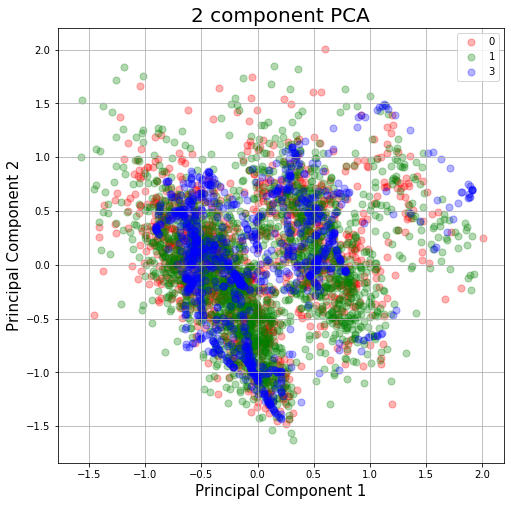

In [55]:
# Before Sampling

Y = df["Winner"]
PCA_df = df.drop(columns = ["Winner"])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,3]
colors = ['r', 'g','b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

([<matplotlib.axis.XTick at 0x1a1f5e4ef0>,
 <a list of 12 Text xticklabel objects>)

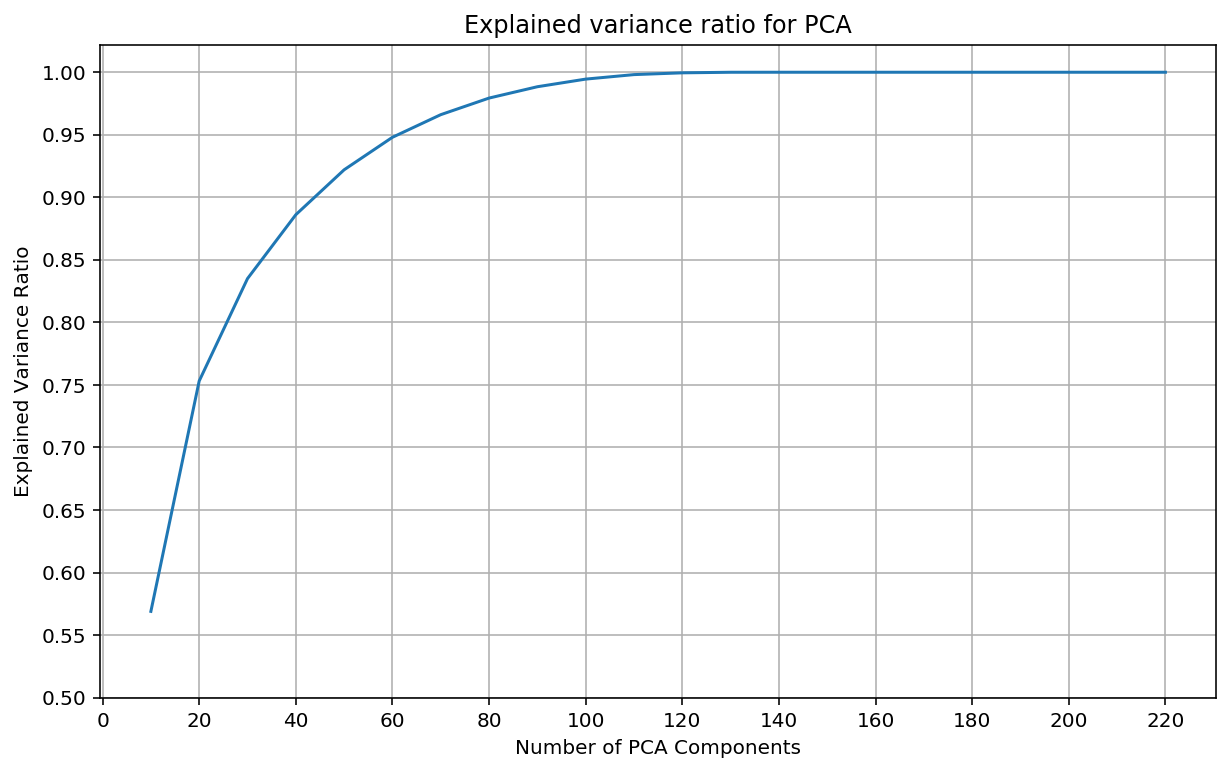

In [56]:
candidate_components = range(10, 225, 10)
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(df.drop(columns = ["Winner"]))
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5, 1.05, .05))
plt.xticks(np.arange(0, 240, 20))

In [57]:
df.loc[:,~df.columns.duplicated()]


,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight,Differencecurrent_lose_streak,Differencecurrent_win_streak,Differencedraw,Differenceavg_BODY_att,Differenceavg_BODY_landed,Differenceavg_CLINCH_att,Differenceavg_CLINCH_landed,Differenceavg_DISTANCE_att,Differenceavg_DISTANCE_landed,Differenceavg_GROUND_att,Differenceavg_GROUND_landed,Differenceavg_HEAD_att,Differenceavg_HEAD_landed,Differenceavg_KD,Differenceavg_LEG_att,Differenceavg_LEG_landed,Differenceavg_PASS,Differenceavg_REV,Differenceavg_SIG_STR_att,Differenceavg_SIG_STR_landed,Differenceavg_SIG_STR_pct,Differenceavg_SUDifferenceATT,Differenceavg_TD_att,Differenceavg_TD_landed,Differenceavg_TD_pct,Differenceavg_TOTAL_STR_att,Differenceavg_TOTAL_STR_landed,Differencelongest_win_streak,Differencelosses,Differenceavg_opp_BODY_att,Differenceavg_opp_BODY_landed,Differenceavg_opp_CLINCH_att,Differenceavg_opp_CLINCH_landed,Differenceavg_opp_DISTANCE_att,Differenceavg_opp_DISTANCE_landed,Differenceavg_opp_GROUND_att,Differenceavg_opp_GROUND_landed,Differenceavg_opp_HEAD_att,Differenceavg_opp_HEAD_landed,Differenceavg_opp_KD,Differenceavg_opp_LEG_att,Differenceavg_opp_LEG_landed,Differenceavg_opp_PASS,Differenceavg_opp_REV,Differenceavg_opp_SIG_STR_att,Differenceavg_opp_SIG_STR_landed,Differe

In [16]:
dataset = shuffle(sampled_df)


Valid_dataset = dataset[:100]
Train_dataset = dataset[100:-100]
Test_dataset = dataset[-100:]

Train_X = Train_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Train_Y = Train_dataset["Winner"].to_numpy(dtype = int)


Valid_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Valid_Y = Valid_dataset["Winner"].to_numpy(dtype = int)


Test_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Test_Y = Valid_dataset["Winner"].to_numpy(dtype = int)

In [31]:
NN = MLPClassifier(solver='adam',  # weight optimization
                    activation='relu',  # activation function
                    alpha=1e-2, # Regularizer value
                    learning_rate_init = 0.07,
                    hidden_layer_sizes=(12,10,9), # layer and node (node,node) --> numbers of layers
#                     hidden_layer_sizes=(128,64,32,16), # layer and node (node,node) --> numbers of layers


                  random_state=1, #random state
                    max_iter = 1000, # max iteration
                    early_stopping = True) # early stop

NN.fit(Train_X, Train_Y) # fit the neural network
NN.score(Train_X,Train_Y)

0.6845959595959596

In [32]:
print(sklearn.metrics.classification_report(Train_Y, NN.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1095
           1       0.63      0.95      0.76      1917
           3       0.83      0.95      0.89       948

    accuracy                           0.68      3960
   macro avg       0.49      0.63      0.55      3960
weighted avg       0.50      0.68      0.58      3960



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
# Bagging for the model and return the best selection via given datasets
rng = np.random.RandomState(1)

def Bagging(model, Train_X, Train_Y, Vail_X, Vail_Y):  
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    for i in range(1, 20):
        Bagging_Model = BaggingClassifier(base_estimator= model, n_estimators = i, bootstrap=True, warm_start=False) #
        Bagging_Model.fit(Train_X, Train_Y)
        curr_score = Bagging_Model.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest



In [41]:
coeff, highest = Bagging(NN, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

(9, 0.74)

In [46]:
Bagging_NN = BaggingClassifier(base_estimator=NN, n_estimators=coeff, random_state=rng)
Bagging_NN.fit(Train_X, Train_Y)
Bagging_NN.score(Train_X,Train_Y)

0.48409090909090907

In [47]:
print(sklearn.metrics.classification_report(Train_Y, NN.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1095
           1       0.63      0.95      0.76      1917
           3       0.83      0.95      0.89       948

    accuracy                           0.68      3960
   macro avg       0.49      0.63      0.55      3960
weighted avg       0.50      0.68      0.58      3960



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
target_0 = df.loc[df['Winner'] == 0]
target_1 = df.loc[df['Winner'] == 1]
target_2 = df.loc[df['Winner'] == 3]

sns.distplot(target_0[['no_of_rounds']], hist=False, rug=True, color = "red")
sns.distplot(target_1[['no_of_rounds']], hist=False, rug=True, color = "blue")
sns.distplot(target_2[['no_of_rounds']], hist=False, rug=True, color = "green")

plt.show()